### 1. Recolha e Preparação de dados

In [1]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.window import *
import pandas as pd
import matplotlib.pyplot as plt

client = MongoClient('mongodb://mongodb:27017/')
db = client.projeto
c_atrasos = db.atrasos
c_voos = db.voos

print(c_atrasos.find_one())
print(c_voos.find_one())

client.close()

{'_id': ObjectId('676ed62b177c65a442d95605'), 'year': 2023, 'month': 8, 'carrier': '9E', 'carrier_name': 'Endeavor Air Inc.', 'airport': 'ABE', 'airport_name': 'Allentown/Bethlehem/Easton, PA: Lehigh Valley International', 'arr_flights': 89.0, 'arr_del15': 13.0, 'carrier_ct': 2.25, 'weather_ct': 1.6, 'nas_ct': 3.16, 'security_ct': 0.0, 'late_aircraft_ct': 5.99, 'arr_cancelled': 2.0, 'arr_diverted': 1.0, 'arr_delay': 1375.0, 'carrier_delay': 71.0, 'weather_delay': 761.0, 'nas_delay': 118.0, 'security_delay': 0.0, 'late_aircraft_delay': 425.0}
{'_id': ObjectId('676ef5e70a6bf8a76f22671a'), 'Unnamed: 0': 6256560, 'ItinID': 201835057271, 'MktID': 20183505727101, 'MktCoupons': 1, 'Quarter': 3, 'Origin': 'MCO', 'OriginWac': 33, 'Dest': 'BWI', 'DestWac': 35, 'Miles': 787.0, 'ContiguousUSA': 2, 'NumTicketsOrdered': 2.0, 'AirlineCompany': 'WN', 'PricePerTicket': 96.0}


In [2]:
spark = SparkSession.builder \
    .appName("Voos e atrasos em 2018") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/projeto") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/projeto") \
    .getOrCreate()

df_atrasos = spark.read.format("mongo").option("collection", "atrasos").load()
df_voos = spark.read.format("mongo").option("collection", "voos").load()

In [3]:
print(df_atrasos.printSchema())
print(df_voos.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- arr_cancelled: double (nullable = true)
 |-- arr_del15: double (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- arr_diverted: double (nullable = true)
 |-- arr_flights: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- carrier_ct: double (nullable = true)
 |-- carrier_delay: double (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- late_aircraft_ct: double (nullable = true)
 |-- late_aircraft_delay: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- nas_ct: double (nullable = true)
 |-- nas_delay: double (nullable = true)
 |-- security_ct: double (nullable = true)
 |-- security_delay: double (nullable = true)
 |-- weather_ct: double (nullable = true)
 |-- weather_delay: double (nullable = true)
 |-- year: integer (nullable = true)

None
root
 |-- AirlineC

In [4]:
df_atrasos = df_atrasos.drop("carrier","airport_name","FLIGHT_NUM","ORIGIN_SEQ_ID","DEST_SEQ_ID","DEP_TIME","ARR_TIME","WEATHER_DELAY", "_id")
df_atrasos = df_atrasos.filter(df_atrasos["year"] == 2018)
df_atrasos = df_atrasos.filter((df_atrasos["month"] >= 7) & (df_atrasos["month"] <= 9))

df_atrasos = df_atrasos.dropna()

df_atrasos = df_atrasos.dropDuplicates()

null_atrasos = df_atrasos.select([count(when(col(c).isNull(), c)).alias(c) for c in df_atrasos.columns])

null_atrasos.show()

+-------+-------------+---------+---------+------------+-----------+----------+-------------+------------+----------------+-------------------+-----+------+---------+-----------+--------------+----------+----+
|airport|arr_cancelled|arr_del15|arr_delay|arr_diverted|arr_flights|carrier_ct|carrier_delay|carrier_name|late_aircraft_ct|late_aircraft_delay|month|nas_ct|nas_delay|security_ct|security_delay|weather_ct|year|
+-------+-------------+---------+---------+------------+-----------+----------+-------------+------------+----------------+-------------------+-----+------+---------+-----------+--------------+----------+----+
|      0|            0|        0|        0|           0|          0|         0|            0|           0|               0|                  0|    0|     0|        0|          0|             0|         0|   0|
+-------+-------------+---------+---------+------------+-----------+----------+-------------+------------+----------------+-------------------+-----+------+----

In [5]:
df_voos = df_voos.drop("ItinID","MktID","MktCoupons","ContiguousUSA","NumTicketsOrdered","AirlineCompany", "_id", "Unnamed: 0")

df_voos = df_voos.dropna()

df_voos = df_voos.dropDuplicates()

null_voos = df_voos.select([count(when(col(c).isNull(), c)).alias(c) for c in df_voos.columns])

null_voos.show()

+----+-------+-----+------+---------+--------------+-------+
|Dest|DestWac|Miles|Origin|OriginWac|PricePerTicket|Quarter|
+----+-------+-----+------+---------+--------------+-------+
|   0|      0|    0|     0|        0|             0|      0|
+----+-------+-----+------+---------+--------------+-------+



In [6]:
df_atrasos = df_atrasos.withColumn("index", monotonically_increasing_id())

window_spec = Window.orderBy("airport")

df_atrasos = df_atrasos.withColumn("index", row_number().over(window_spec) - 1)

### 2. Análise exploratória

#### Aeroportos com mais atrasos de 15+ minutos

In [7]:
top5_delays = (
    df_atrasos.groupBy("airport")
    .agg(sum("arr_del15").alias("total_delays"))
    .orderBy(col("total_delays").desc())
    .limit(5)
)

top5_delays.show()

+-------+------------+
|airport|total_delays|
+-------+------------+
|    ORD|     19543.0|
|    ATL|     15905.0|
|    DFW|     15661.0|
|    EWR|     11931.0|
|    SFO|     11763.0|
+-------+------------+



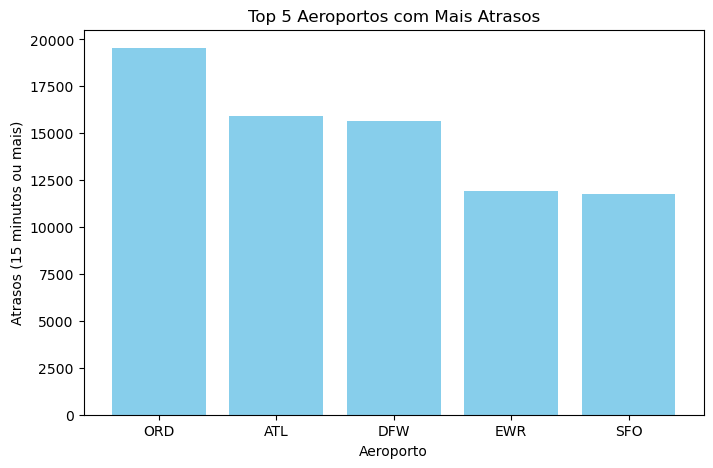

In [8]:
top5_delays_pandas = top5_delays.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(top5_delays_pandas["airport"], top5_delays_pandas["total_delays"], color="skyblue")
plt.xlabel("Aeroporto")
plt.ylabel("Atrasos (15 minutos ou mais)")
plt.title("Top 5 Aeroportos com Mais Atrasos")
plt.show()

#### Média de preços para os aeroportos com mais atrasos

In [9]:
most_delayed_airports = [row["airport"] for row in top5_delays.collect()]

filtered_df = df_voos.filter(df_voos["Dest"].isin(most_delayed_airports))

average_prices = (
    filtered_df.groupBy("Dest")
    .agg(avg("PricePerTicket").alias("AveragePrice"))
)

average_prices.show()

+----+------------------+
|Dest|      AveragePrice|
+----+------------------+
| EWR|277.47552649116955|
| DFW|259.76284489863195|
| SFO| 294.8108275042893|
| ATL|238.67692741935485|
| ORD|249.66102115434853|
+----+------------------+



#### Aeroportos com mais voos cancelados por percentagem

In [10]:
grouped = (
    df_atrasos.groupBy("airport")
    .agg(
        sum("arr_flights").alias("total_flights"),
        sum("arr_cancelled").alias("total_cancelled")
    )
)

grouped = grouped.withColumn(
    "cancelled_percentage",
    (col("total_cancelled") / col("total_flights")) * 100
)

top5_cancelled = grouped.orderBy(col("cancelled_percentage").desc()).limit(5)

top5_cancelled.select("airport", "cancelled_percentage").show()

+-------+--------------------+
|airport|cancelled_percentage|
+-------+--------------------+
|    OGS|  14.285714285714285|
|    PGV|    9.72568578553616|
|    HVN|            8.984375|
|    OAJ|   8.551068883610451|
|    ILM|    8.13424345847554|
+-------+--------------------+

